Wczytywanie zbioru danych:

https://idiotdeveloper.com/image-segmentation-based-background-removal-in-tensorflow/

In [ ]:
H = 512
W = 512

In [10]:
from sklearn.utils import shuffle
def shuffling(x, y):
    x, y = shuffle(x, y, random_state=1)
    return x, y

In [3]:
from sklearn.model_selection import train_test_split
from glob import glob
import os
import pathlib

base_path = pathlib.Path(
    'person segmentation',
    'people_segmentation',
)

def load_data(path: pathlib.Path, split: float = 0.1):
    images_dir = path / 'images'
    masks_dir = path / 'masks'
    X = sorted(map(str, images_dir.iterdir()))
    Y = sorted(map(str, masks_dir.iterdir()))
    split_size = int(len(X) * split)

    train_x, test_x = train_test_split(X, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(Y, test_size=split_size, random_state=42)

    split_val = split / (1 - split)
    train_x, val_x = train_test_split(train_x, test_size=split_val, random_state=42)
    train_y, val_y = train_test_split(train_y, test_size=split_val, random_state=42)


    return (train_x, train_y), (val_x, val_y), (test_x, test_y)

(train_x, train_y), (val_x, val_y), (test_x, test_y) = load_data(base_path)
print(len(train_x), len(train_y), len(val_x), len(val_y), len(test_x), len(test_y))

4543 4543 568 568 567 567


In [36]:
import numpy as np
import cv2
import matplotlib.image as mpimg

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = x/255.0
    x = x.astype(np.float32)
    return x


def read_mask(path):
    # path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

In [37]:
read_image(train_x[0])

array([[[0.5882353 , 0.52156866, 0.59607846],
        [0.5882353 , 0.52156866, 0.59607846],
        [0.5882353 , 0.52156866, 0.59607846],
        ...,
        [0.5882353 , 0.57254905, 0.6627451 ],
        [0.5882353 , 0.57254905, 0.6627451 ],
        [0.5882353 , 0.57254905, 0.6627451 ]],

       [[0.5882353 , 0.52156866, 0.59607846],
        [0.5882353 , 0.52156866, 0.59607846],
        [0.5882353 , 0.52156866, 0.59607846],
        ...,
        [0.5921569 , 0.5764706 , 0.6666667 ],
        [0.5882353 , 0.57254905, 0.6627451 ],
        [0.5882353 , 0.57254905, 0.6627451 ]],

       [[0.5921569 , 0.5176471 , 0.59607846],
        [0.5921569 , 0.5176471 , 0.59607846],
        [0.5921569 , 0.5176471 , 0.59607846],
        ...,
        [0.5921569 , 0.5764706 , 0.6666667 ],
        [0.5921569 , 0.5764706 , 0.6666667 ],
        [0.5882353 , 0.57254905, 0.6627451 ]],

       ...,

       [[0.24313726, 0.29411766, 0.47058824],
        [0.25490198, 0.30588236, 0.48235294],
        [0.26666668, 0

In [48]:
from matplotlib import pyplot as plt


def show_img(img):
    plt.imshow(img)
    plt.show()

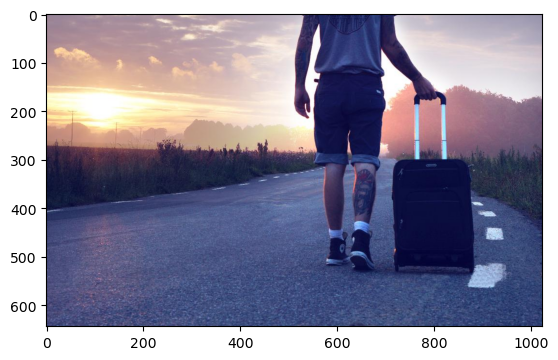

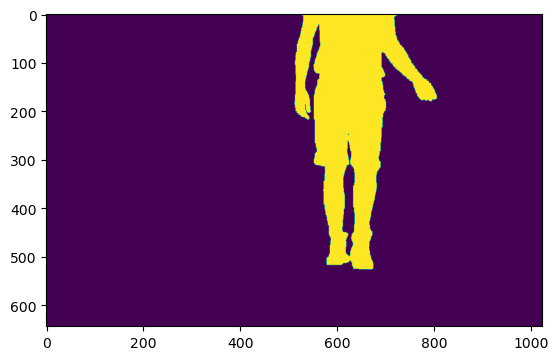

In [50]:
show_img(read_image(train_x[0]))
show_img(read_mask(train_y[0]))

Tworzenie modelu:

In [51]:
TRAIN_LENGTH = len(train_x)
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE


In [57]:
import tensorflow as tf


def augment_data(images, masks): 
    seed = 15
    augment_images = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    augment_masks = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    return zip(augment_images, augment_masks)
